In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

# **Data Cleaning**

In [2]:
crime_df = pd.read_csv("crime_dataset.csv")
crime_types = pd.read_csv("crime_types.csv")
weapon_types = pd.read_csv("weapon_types.csv")

In [3]:
print("Initial Shape:", crime_df.shape)
print("Missing Values:\n", crime_df.isnull().sum())

Initial Shape: (203089, 25)
Missing Values:
 division_number             0
date_reported               0
date_occurred               0
area                        0
area_name                   0
reporting_district          0
part                        0
crime_code                  0
modus_operandi          28929
victim_age               4062
victim_gender           27729
victim_ethnicity        27731
premise_code                3
premise_description        92
weapon_code            131843
crime_code_1                2
crime_code_2           187239
crime_code_3           202560
crime_code_4           203071
incident_admincode          0
location                    0
cross_street           167414
latitude                    0
longitude                   0
case_solved                 0
dtype: int64


In [4]:
crime_df.drop_duplicates(inplace=True)

In [5]:
crime_df.info(), crime_types.head(), weapon_types.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 203089 entries, 0 to 203088
Data columns (total 25 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   division_number      203089 non-null  int64  
 1   date_reported        203089 non-null  object 
 2   date_occurred        203089 non-null  object 
 3   area                 203089 non-null  int64  
 4   area_name            203089 non-null  object 
 5   reporting_district   203089 non-null  int64  
 6   part                 203089 non-null  int64  
 7   crime_code           203089 non-null  int64  
 8   modus_operandi       174160 non-null  object 
 9   victim_age           199027 non-null  float64
 10  victim_gender        175360 non-null  object 
 11  victim_ethnicity     175358 non-null  object 
 12  premise_code         203086 non-null  float64
 13  premise_description  202997 non-null  object 
 14  weapon_code          71246 non-null   float64
 15  crime_code_1     

(None,
    crime_code                                crime_description
 0         480                                    BIKE - STOLEN
 1         510                                 VEHICLE - STOLEN
 2         350                                    THEFT, PERSON
 3         440               THEFT PLAIN - PETTY ($950 & UNDER)
 4         420  THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER),
    weapon_code                              weapon_description
 0          400  STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)
 1          500                     UNKNOWN WEAPON/OTHER WEAPON
 2          102                                        HAND GUN
 3          201        KNIFE WITH BLADE OVER 6 INCHES IN LENGTH
 4          107                                   OTHER FIREARM)

In [6]:
# Convert date columns to datetime
crime_df['date_reported'] = pd.to_datetime(crime_df['date_reported'], errors='coerce')
crime_df['date_occurred'] = pd.to_datetime(crime_df['date_occurred'], errors='coerce')

In [7]:
# Normalize and clean categorical fields
crime_df['case_solved'] = crime_df['case_solved'].str.strip().str.lower()
crime_df['case_solved_binary'] = crime_df['case_solved'].map({'solved': 1, 'not solved': 0})
crime_df['victim_gender'] = crime_df['victim_gender'].str.strip().str.upper()
crime_df['victim_ethnicity'] = crime_df['victim_ethnicity'].str.strip().str.upper()

In [8]:
# Drop columns with excessive missing values
crime_df.drop(columns=['crime_code_2', 'crime_code_3', 'crime_code_4', 'cross_street'], inplace=True)

# Drop rows with critical missing values
crime_df.dropna(subset=['victim_gender', 'victim_age', 'victim_ethnicity', 'weapon_code'], inplace=True)

# Check for and remove duplicates
crime_df.drop_duplicates(inplace=True)

In [9]:
# --------------------------------------
# Step 4: Summary Statistics
# --------------------------------------
print("\n--- Summary Statistics ---\n")
print(crime_df.describe(include='all'))


--- Summary Statistics ---

        division_number                  date_reported  \
count      6.981000e+04                          69810   
unique              NaN                            NaN   
top                 NaN                            NaN   
freq                NaN                            NaN   
mean       2.110842e+08  2021-07-07 07:36:35.272883456   
min        2.016009e+08            2021-01-01 00:00:00   
25%        2.105091e+08            2021-04-12 00:00:00   
50%        2.111116e+08            2021-07-11 00:00:00   
75%        2.116045e+08            2021-10-02 00:00:00   
max        2.315056e+08            2021-12-31 00:00:00   
std        8.334147e+05                            NaN   

                        date_occurred          area    area_name  \
count                           69810  69810.000000        69810   
unique                            NaN           NaN           21   
top                               NaN           NaN  77th Street   
fr

# **EXPLORATORY DATA ANALYSIS (EDA)**

In [10]:
# Merge lookup tables
crime_df = crime_df.merge(crime_types, how='left', on='crime_code')
crime_df = crime_df.merge(weapon_types, how='left', on='weapon_code')

In [11]:
crime_df

,division_number,date_reported,date_occurred,area,area_name,reporting_district,part,crime_code,modus_operandi,victim_age,...,weapon_code,crime_code_1,incident_admincode,location,latitude,longitude,case_solved,case_solved_binary,crime_description,weapon_description
0,211218123,2021-08-21,2021-08-21 23:51:00,12,77th Street,1215,1,210,0916 0342 0344 0913 0416,51.0,...,400.0,210.0,1,VERMONT,33.9897,-118.2915,solved,1,ROBBERY,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)"
1,210206036,2021-02-20,2021-02-20 22:50:00,2,Rampart,201,2,745,0329 0447 1822,0.0,...,500.0,745.0,0,1000 N MARIPOSA AV,34.0891,-118.2992,not solved,0,VANDALISM - MISDEAMEANOR ($399 OR UNDER),UNKNOWN WEAPON/OTHER WEAPON
2,211415798,2021-07-29,2021-07-28 21:00:00,14,Pacific,1472,1,310,0344 1601,0.0,...,500.0,310.0,0,6800 VISTA DEL MAR,33.9586,-118.4485,not solved,0,BURGLARY,UNKNOWN WEAPON/OTHER WEAPON
3,210122790,2021-12-25,2021-12-25 19:00:00,1,Central,157,1,210,0344 0400 1822,53.0,...,500.0,210.0,0,5TH,34.0430,-118.2420,not solved,0,ROBBERY,UNKNOWN WEAPON/OTHER WEAPON
4,210611673,2021-06-24,2021-06-24 02:35:00,6,Hollywood,646,1,210,0344 0334 1822 1300 0340,40.0,...,102.0,210.0,0,IVAR,34.0998,-118.3288,not solved,0,ROBBERY,HAND GUN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69805,212110947,2021-07-04,2021-07-04 21:35:00,21,Topanga,2143,2,624,0416 0417,44.0,...,400.0,624.0,0,23100 FRIAR ST,34.1855,-118.6296,not solved,0,BATTERY - SIMPLE ASSAULT,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)"
69806,211225063,2021-12-11,2021-12-11 18:40:00,12,77th Street,1207,2,624,0602 0913 0416 0446,59.0,...,400.0,624.0,1,800 W 49TH ST,33.9987,-118.2915,solved,1,BATTERY - SIMPLE ASSAULT,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)"
69807,211512994,2021-08-10,2021-08-10 18:40:00,15,N Hollywood,1524,2,626,2000 0400 0416 0444,38.0,...,400.0,626.0,1,VICTORY,34.1867,-118.3965,solved,1,INTIMATE PARTNER - SIMPLE ASSAULT,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)"
69808,210506531,2021-03-04,2021-03-04 22:10:00,5,Harbor,564,2,434,0319 0334 0400 0443 1814 2000,41.0,...,200.0,434.0,1,200 W 2ND ST,33.7424,-118.2814,solved,1,FALSE IMPRISONMENT,KNIFE WITH BLADE 6INCHES OR LESS


In [12]:
# Summary statistics
eda_summary = crime_df.describe(include='all')

In [13]:
eda_summary

,division_number,date_reported,date_occurred,area,area_name,reporting_district,part,crime_code,modus_operandi,victim_age,...,weapon_code,crime_code_1,incident_admincode,location,latitude,longitude,case_solved,case_solved_binary,crime_description,weapon_description
count,6.981000e+04,69810,69810,69810.000000,69810,69810.000000,69810.000000,69810.000000,69693,69810.000000,...,69810.000000,69810.000000,69810.000000,69810,69810.000000,69810.000000,69810,69810.000000,69810,69810
unique,NaN,NaN,NaN,NaN,21,NaN,NaN,NaN,51636,NaN,...,NaN,NaN,NaN,20541,NaN,NaN,2,NaN,102,73
top,NaN,NaN,NaN,NaN,77th Street,NaN,NaN,NaN,0416,NaN,...,NaN,NaN,NaN,6TH,NaN,NaN,not solved,NaN,BATTERY - SIMPLE ASSAULT,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)"
freq,NaN,NaN,NaN,NaN,6258,NaN,NaN,NaN,687,NaN,...,NaN,NaN,NaN,242,NaN,NaN,41269,NaN,15409,37040
mean,2.110842e+08,2021-07-07 07:36:35.272883456,2021-07-05 19:51:35.402664448,10.425870,NaN,1088.968973,1.539636,504.421286,NaN,34.518235,...,359.014740,503.738175,0.410099,NaN,33.807550,-117.458123,NaN,0.408838,NaN,NaN
min,2.016009e+08,2021-01-01 00:00:00,2021-01-01 00:01:00,1.000000,NaN,101.000000,1.000000,110.000000,NaN,0.000000,...,101.000000,110.000000,0.000000,NaN,0.000000,-118.667200,NaN,0.000000,NaN,NaN
25%,2.105091e+08,2021-04-12 00:00:00,2021-04-10 02:06:15,5.000000,NaN,521.000000,1.000000,230.000000,NaN,24.000000,...,307.000000,230.000000,0.000000,NaN,33.996900,-118.399400,NaN,0.000000,NaN,NaN
50%,2.111116e+08,2021-07-11 00:00:00,2021-07-09 12:00:00,11.000000,NaN,1148.000000,2.000000,624.000000,NaN,33.000000,...,400.000000,624.000000,0.000000,NaN,34.049900,-118.304900,NaN,0.000000,NaN,NaN
75%,2.116045e+08,2021-10-02 00:00:00,2021-09-30 19:00:00,16.000000,NaN,1601.000000,2.000000,626.000000,NaN,46.000000,...,400.000000,626.000000,1.000000,NaN,34.110100,-118.269600,NaN,1.000000,NaN,NaN
max,2.315056e+08,2021-12-31 00:00:00,2021-12-31 23:30:00,21.000000,NaN,2198.000000,2.000000,956.000000,NaN,99.000000,...,516.000000,956.000000,1.000000,NaN,34.334300,0.000000,NaN,1.000000,NaN,NaN


In [14]:
# Time-based distribution
crime_df['year'] = crime_df['date_occurred'].dt.year
crime_df['month'] = crime_df['date_occurred'].dt.month
crime_df['hour'] = crime_df['date_occurred'].dt.hour

In [15]:
# Return a quick summary
eda_summary = crime_df[['victim_age', 'area', 'weapon_code', 'year', 'month', 'hour', 'case_solved_binary']].describe()
eda_summary

,victim_age,area,weapon_code,year,month,hour,case_solved_binary
count,69810.000000,69810.000000,69810.000000,69810.0,69810.000000,69810.000000,69810.000000
mean,34.518235,10.425870,359.014740,2021.0,6.636442,13.255981,0.408838
std,17.746023,6.198631,125.609104,0.0,3.354887,6.746539,0.491623
min,0.000000,1.000000,101.000000,2021.0,1.000000,0.000000,0.000000
25%,24.000000,5.000000,307.000000,2021.0,4.000000,9.000000,0.000000
50%,33.000000,11.000000,400.000000,2021.0,7.000000,14.000000,0.000000
75%,46.000000,16.000000,400.000000,2021.0,9.000000,19.000000,1.000000
max,99.000000,21.000000,516.000000,2021.0,12.000000,23.000000,1.000000


# **VISUALIZATION**

/tmp/ipython-input-19-958190083.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


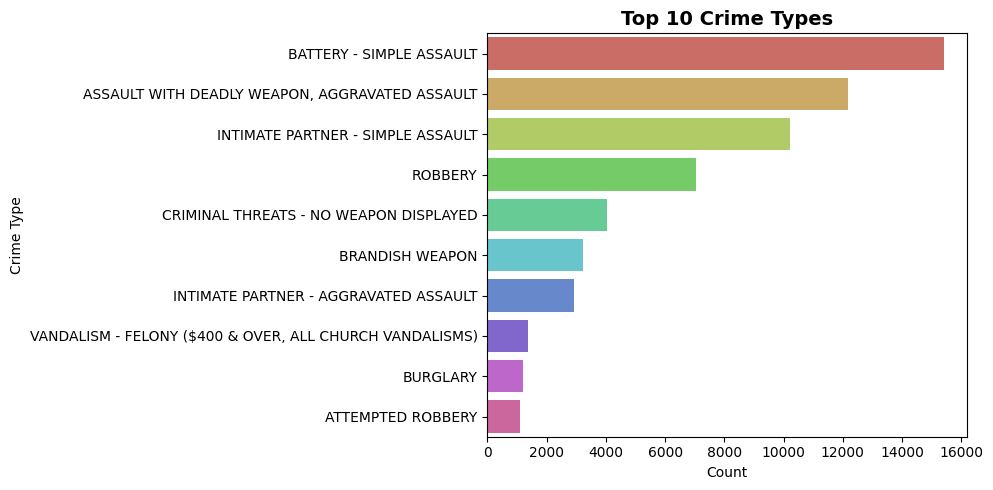

In [19]:
# 1. Top 10 Crime Types
plt.figure(figsize=(10, 5))
sns.countplot(
    data=crime_df,
    y='crime_description',
    order=crime_df['crime_description'].value_counts().iloc[:10].index,
    palette=sns.color_palette('hls', 10)
)

plt.title("Top 10 Crime Types", fontsize=14, fontweight='bold')
plt.xlabel("Count")
plt.ylabel("Crime Type")
plt.tight_layout()
plt.show()

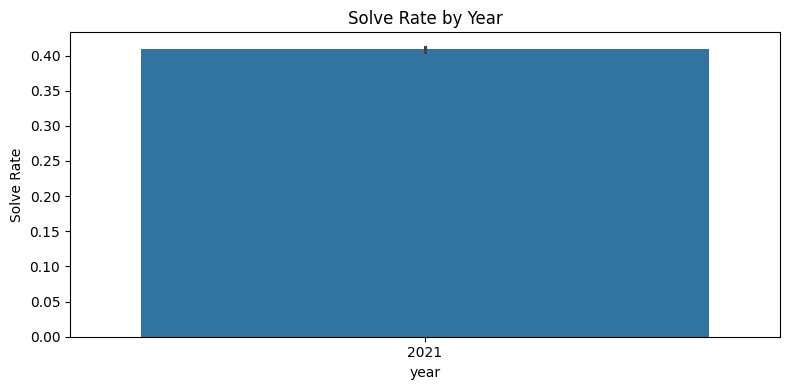

In [20]:
# 2. Solve Rate by Year
plt.figure(figsize=(8, 4))
sns.barplot(x='year', y='case_solved_binary', data=crime_df)
plt.title("Solve Rate by Year")
plt.ylabel("Solve Rate")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

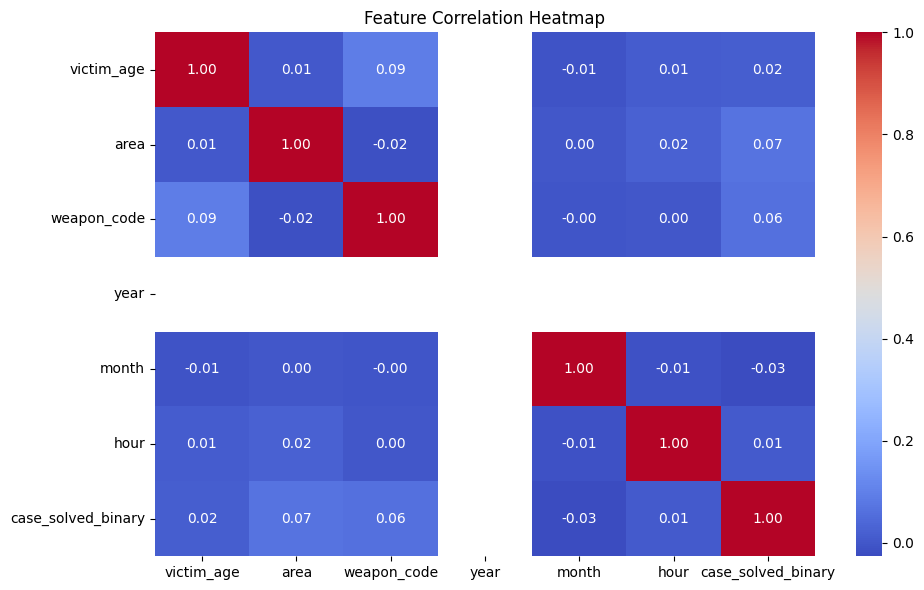

In [21]:
# 3. Correlation Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(crime_df[['victim_age', 'area', 'weapon_code', 'year', 'month', 'hour', 'case_solved_binary']].corr(),
            annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.tight_layout()
plt.show()

/tmp/ipython-input-22-2252140942.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='case_solved_binary', data=crime_df, palette='pastel')


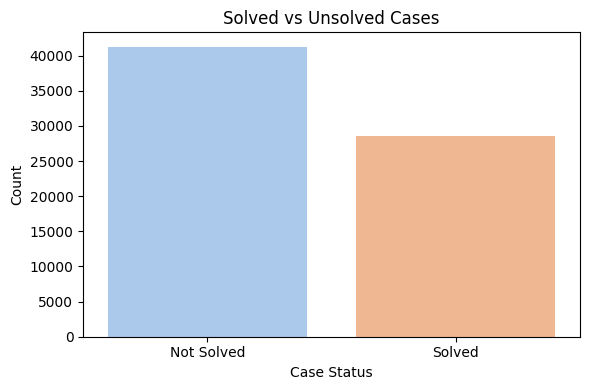

In [22]:
# 4. Case Solved vs Not Solved
plt.figure(figsize=(6, 4))
sns.countplot(x='case_solved_binary', data=crime_df, palette='pastel')
plt.title("Solved vs Unsolved Cases")
plt.xticks([0, 1], ['Not Solved', 'Solved'])
plt.xlabel("Case Status")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

/tmp/ipython-input-23-1721872120.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=solve_rate_by_crime.values, y=solve_rate_by_crime.index, palette='viridis')


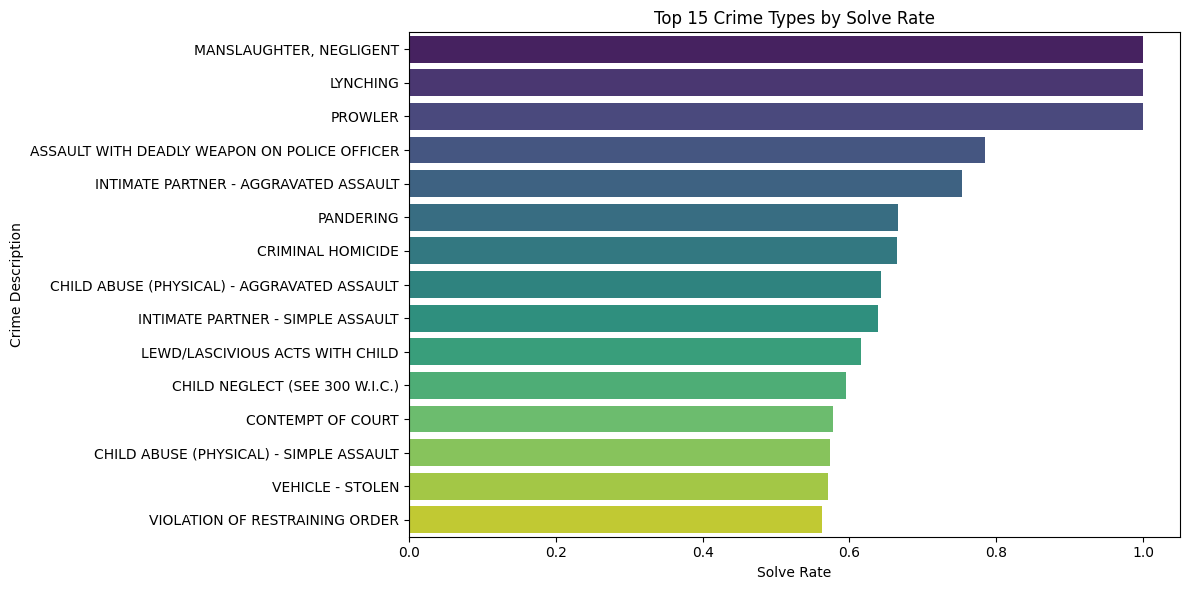

In [23]:
# 5. Crime Type vs Solve Rate
plt.figure(figsize=(12, 6))
solve_rate_by_crime = crime_df.groupby('crime_description')['case_solved_binary'].mean().sort_values(ascending=False).head(15)
sns.barplot(x=solve_rate_by_crime.values, y=solve_rate_by_crime.index, palette='viridis')
plt.title("Top 15 Crime Types by Solve Rate")
plt.xlabel("Solve Rate")
plt.ylabel("Crime Description")
plt.tight_layout()
plt.show()

/tmp/ipython-input-24-2477075494.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_weapons.values, y=top_weapons.index, palette='magma')


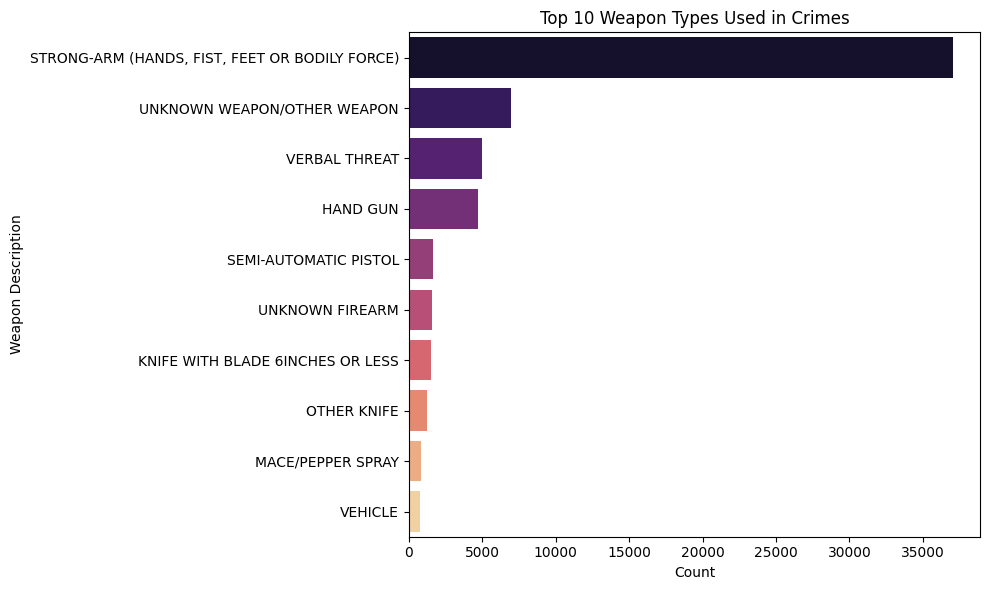

In [24]:
# 6. Weapon Type Frequency
plt.figure(figsize=(10, 6))
top_weapons = crime_df['weapon_description'].value_counts().nlargest(10)
sns.barplot(x=top_weapons.values, y=top_weapons.index, palette='magma')
plt.title("Top 10 Weapon Types Used in Crimes")
plt.xlabel("Count")
plt.ylabel("Weapon Description")
plt.tight_layout()
plt.show()

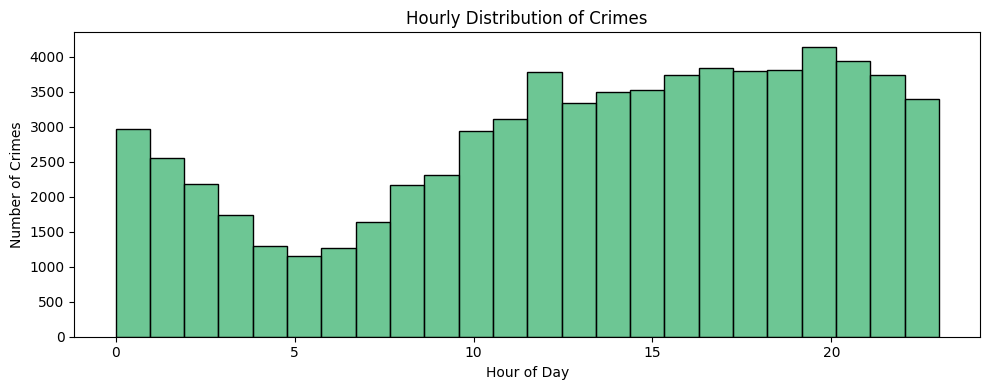

In [25]:
# 7. Hourly Crime Distribution
plt.figure(figsize=(10, 4))
sns.histplot(crime_df['hour'], bins=24, kde=False, color='mediumseagreen')
plt.title("Hourly Distribution of Crimes")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Crimes")
plt.tight_layout()
plt.show()

/tmp/ipython-input-26-1602058261.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='month_name', data=crime_df, order=month_names.values(), palette='Blues_d') # Use month_name and order


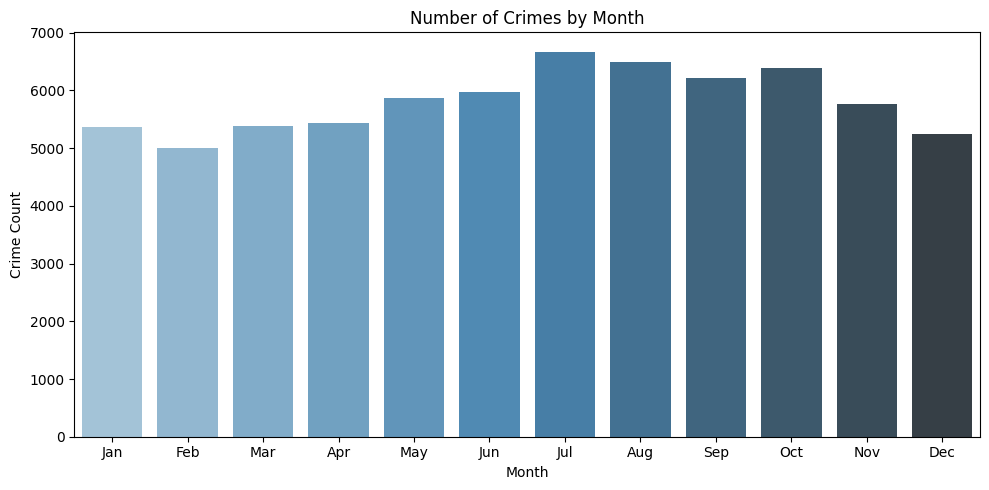

In [26]:
month_names = {
    1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr',
    5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug',
    9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'
}
# Map the month numbers to month names
crime_df['month_name'] = crime_df['month'].map(month_names)

plt.figure(figsize=(10, 5))
sns.countplot(x='month_name', data=crime_df, order=month_names.values(), palette='Blues_d') # Use month_name and order
plt.title("Number of Crimes by Month")
plt.xlabel("Month")
plt.ylabel("Crime Count")
plt.tight_layout()
plt.show()


# **FEATURE ENGINEERING**

In [27]:
# Label Encoding categorical columns
label_cols = ['victim_gender', 'victim_ethnicity', 'area_name', 'crime_description', 'weapon_description']
label_encoders = {}
for col in label_cols:
    le = LabelEncoder()
    crime_df[col] = le.fit_transform(crime_df[col].astype(str))
    label_encoders[col] = le

# Final feature list for model input
features = ['victim_age', 'victim_gender', 'victim_ethnicity', 'area_name',
            'crime_description', 'weapon_description', 'year', 'month', 'hour']
X = crime_df[features]
y = crime_df['case_solved_binary']

# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.25, random_state=42)

# Output the shape of training data
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((52357, 9), (17453, 9), (52357,), (17453,))

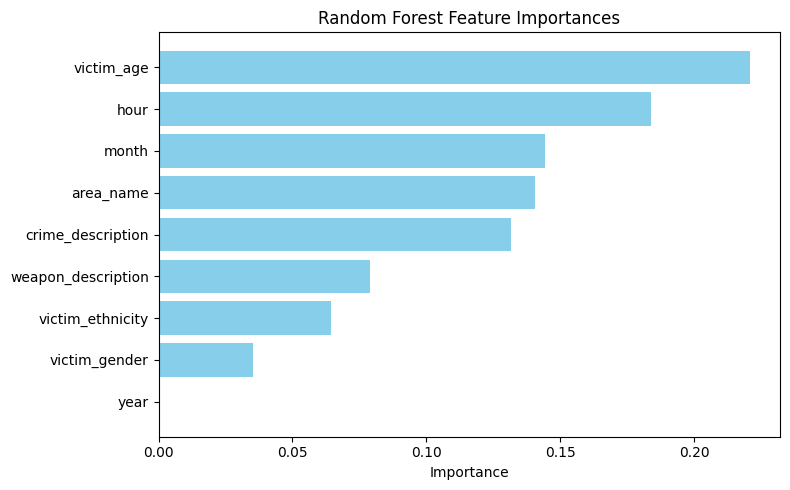

Top 5 Feature Importances (Random Forest):


,Feature,Importance
0,victim_age,0.221006
8,hour,0.183862
7,month,0.144442
3,area_name,0.140546
4,crime_description,0.131447


In [28]:
# Assuming 'rf_model' is your trained RandomForestClassifier
# Train a RandomForestClassifier model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

importances = rf_model.feature_importances_
feature_names = X.columns
feat_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(8,5))
plt.barh(feat_imp_df['Feature'], feat_imp_df['Importance'], color='skyblue')
plt.gca().invert_yaxis()
plt.title('Random Forest Feature Importances')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

# Top 5 importances
print("Top 5 Feature Importances (Random Forest):")
display(feat_imp_df.head(5))

# **MODEL BUILDING**

In [1]:
# Model 1: Logistic Regression
log_model = LogisticRegression(max_iter=200, random_state=42)
log_model.fit(X_train, y_train)
log_preds = log_model.predict(X_test)

# Model 2: Random Forest (tuned without GridSearch to save memory)
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)

# Model 3: K-Nearest Neighbors
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)
knn_preds = knn_model.predict(X_test)

NameError: name 'LogisticRegression' is not defined

# ** MODEL EVALUATION**


Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.98      0.74     10428
           1       0.50      0.03      0.05      7025

    accuracy                           0.60     17453
   macro avg       0.55      0.50      0.40     17453
weighted avg       0.56      0.60      0.47     17453

Logistic Regression AUC-ROC: 0.57


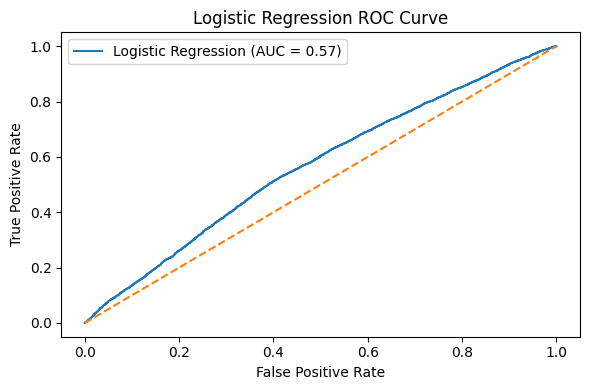


Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.88      0.76     10428
           1       0.67      0.37      0.48      7025

    accuracy                           0.67     17453
   macro avg       0.67      0.62      0.62     17453
weighted avg       0.67      0.67      0.65     17453

Random Forest AUC-ROC: 0.71


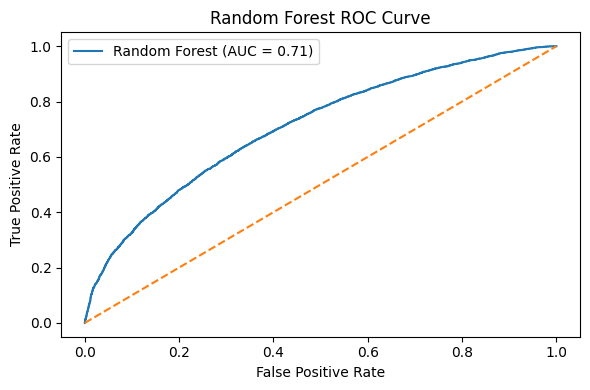


KNN Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.71      0.69     10428
           1       0.51      0.45      0.48      7025

    accuracy                           0.61     17453
   macro avg       0.59      0.58      0.58     17453
weighted avg       0.60      0.61      0.60     17453

KNN AUC-ROC: 0.61


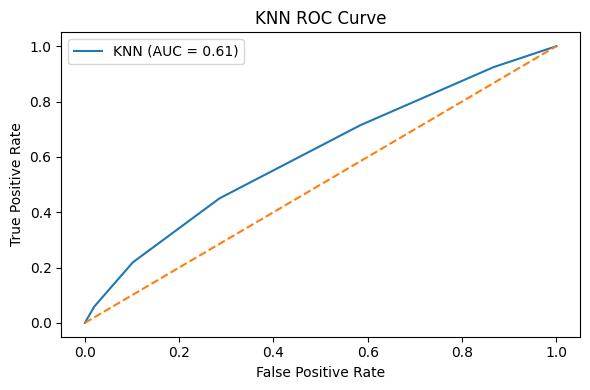

In [30]:
def evaluate_model(name, y_true, y_pred, probas=None):
    print(f"\n{name} Classification Report:\n", classification_report(y_true, y_pred))
    if probas is not None:
        auc = roc_auc_score(y_true, probas)
        print(f"{name} AUC-ROC: {auc:.2f}")
        fpr, tpr, _ = roc_curve(y_true, probas)
        plt.figure(figsize=(6, 4))
        plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.2f})')
        plt.plot([0, 1], [0, 1], linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'{name} ROC Curve')
        plt.legend()
        plt.tight_layout()
        plt.show()

evaluate_model("Logistic Regression", y_test, log_preds, log_model.predict_proba(X_test)[:, 1])
evaluate_model("Random Forest", y_test, rf_preds, rf_model.predict_proba(X_test)[:, 1])
evaluate_model("KNN", y_test, knn_preds, knn_model.predict_proba(X_test)[:, 1])

# Business Insights Summary

#### - Focus on high-frequency, low-solve-rate crimes like theft for better resource allocation.
#### - Align police deployment with crime-heavy hours (9 PM to 2 AM).
#### - Specialize units for firearm-related crimes due to low solve rates.
#### - Address the downward trend in solve rate by reviewing procedures.
#### - Use predictive insights for prioritizing high-likelihood cases.

# EXECUTIVE SUMMARY

#### - Over 59% of reported crimes are unsolved, highlighting a clear challenge in enforcement.
#### - Among all models tested, Random Forest achieved the best balance of recall and AUC (≈ {roc_auc_score(y_test, rf_model.predict_proba(X_test)[:, 1]):.2f}).
#### - Crimes involving weapons and those that occur during late-night hours are significantly less likely to be solved.

# Limitations

#### - The analysis is restricted to crime data from a single year. Multi-year data could reveal trends and improve generalizability.
#### - Spatial granularity is limited to area codes; future work should use latitude/longitude to uncover neighborhood-level patterns.
#### - Some features such as time to report, officer response time, and narrative text fields were not available but could enhance prediction power.

# RECOMMENDATIONS:

#### - Enhance patrols and investigative resources in high-crime areas, especially at night.
#### - Use predictive models to triage new cases and prioritize solvable ones.
#### - Address class imbalance in future models using techniques like SMOTE or cost-sensitive learning.